<a href="https://colab.research.google.com/github/ZackAkil/IOD2VOT/blob/main/iod2vot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Size, shape, direction, speed
##  (y_min, x_min, y_max, x_max)

In [7]:
%%writefile iod2vot.py

import numpy as np
import math


class ObjectTrack:
    def __init__(self, track_id, max_distance, max_missing_frames):
        self.track_id = track_id
        self.max_distance = max_distance
        self.max_missing_frames = max_missing_frames
        self.frames = []
        self.distances = []
        self.midpoints = []
        self.directions = []
        self.delta_directions = []
        self.interpolate_missing_frames=True
        self.interpolated_frame_count = 0
        self.current_missed_frames_count = 0


    @property
    def bboxes(self):
      output = []
      for f in self.frames:
        output.append(f[1].tolist())
      return output


    def add_frame(self, frame_num, bbox):

        if bbox is None:
          self.current_missed_frames_count += 1
        else:
          self.current_missed_frames_count = 0

        self.frames.append((frame_num, bbox))


    def get_missed_frames_count(self):

        return self.current_missed_frames_count

        # missed_frames_count = 0
        # for _, bbox in reversed(self.frames):
        #     if bbox is None:
        #         missed_frames_count+=1
        #     else:
        #         return missed_frames_count

    def interpolate_missing_boxes(self):

        boxes = []
        for _, bbox in self.frames:
            if bbox is not None:
                boxes.append(bbox)
            else:
                # create bbox with Nones for each dimention
                boxes.append([None,None,None,None])
                self.interpolated_frame_count += 1

        interpolated = self.interpolate_nones_matrix(boxes)

        for i, new_data in enumerate(interpolated):
            self.frames[i] = (self.frames[i][0], new_data)


    def end_tracking(self):
        '''
        Remove trailing Nones in track and do post processing
        '''
        len_frames = len(self.frames)
        for i in range(len_frames):

            if self.frames[-1][1] is None:
                self.frames.pop()
            else:
                break

        if self.interpolate_missing_frames:
            self.interpolate_missing_boxes()


        self.distances = self.calculate_all_distances(self.frames)

        self.midpoints =  self.calculate_midpoints(self.frames)

        self.directions = self.get_path_directions(self.midpoints)

        self.delta_directions = self.get_delta_directions(self.directions)


    def pick_best_bbox(self, bbox_list):
        '''
        Pick the most similare in shape box within range.
        '''

        bboxes_in_range = []

        for bbox in bbox_list:
            if self.is_in_range(bbox):
                bboxes_in_range.append((bbox, self.get_shape_similarity_score(bbox)))

        if len(bboxes_in_range):
            return sorted(bboxes_in_range, key=lambda x: x[1])[0][0]
        return None


    def get_last_detected_bbox(self):
        for _ , frame in reversed(self.frames):
            if frame is not None:
                return frame


    def get_shape_similarity_score(self, bbox):
        latest_shape = self.get_latest_shape()
        bbox_shape = self.calculate_shape(bbox)
        score = abs(latest_shape[0] - bbox_shape[0]) + abs(latest_shape[1] - bbox_shape[1])
        return score

    @staticmethod
    def calculate_shape(bbox):
        y_min, x_min, y_max, x_max  = bbox
        width = x_max - x_min
        height = y_max - y_min
        return (width, height)


    def get_latest_shape(self):
        return self.calculate_shape(self.get_last_detected_bbox())


    def is_same_track(self, bbox):

        if not self.frames:
            return False

        _, last_bbox = self.get_last_detected_position()
        distance = self.calculate_distance(bbox, last_bbox)
        return distance <= self.max_distance


    def is_in_range(self, bbox):

        # if there are no frames
        if not self.frames:
            return False

        last_bbox = self.get_last_detected_bbox()
        distance = self.calculate_distance(bbox, last_bbox)

        # increase distance to compensate for missed frames
        # TODO this is abit simple, could be looking at extrapolated distance
        distance_boundary = self.max_distance + (self.current_missed_frames_count *  self.max_distance)

        return distance <= distance_boundary


    @staticmethod
    def calculate_all_distances(frames):

        distances = []
        for i in range(len(frames)-1):
            distances.append( ObjectTrack.calculate_distance(frames[i][1],
                                                             frames[i+1][1]) )
        return distances

    @staticmethod
    def calculate_distance(bbox1, bbox2):
        y1_min, x1_min, y1_max, x1_max = bbox1
        y2_min, x2_min, y2_max, x2_max = bbox2
        center1 = np.array([(y1_min + y1_max) / 2, (x1_min + x1_max) / 2])
        center2 = np.array([(y2_min + y2_max) / 2, (x2_min + x2_max) / 2])
        distance = np.linalg.norm(center1 - center2)
        return distance


    @staticmethod
    def calculate_midpoints(bbox_list):
        midpoints = []
        for seconds, bbox in bbox_list:
            ymin, xmin, ymax, xmax = bbox
            midpoint_x = (xmin + xmax) / 2
            midpoint_y = (ymin + ymax) / 2
            midpoint = (midpoint_x, midpoint_y)
            midpoints.append(midpoint)
        return midpoints


    @staticmethod
    def interpolate_nones_matrix(matrix):
        # Convert the matrix to a NumPy array
        arr = np.array(matrix, dtype=float)

        # Iterate through each column
        for col in range(arr.shape[1]):
            # Find indices of None values in the current column
            none_indices = np.where(np.isnan(arr[:, col]))[0]

            # Find indices of non-None values in the current column
            non_none_indices = np.where(~np.isnan(arr[:, col]))[0]

            # do linear interpolation
            arr[none_indices, col] = np.interp(none_indices, non_none_indices, arr[non_none_indices, col])
        return arr


    @staticmethod
    def get_path_directions(path):

        x = np.array([point[0] for point in path])
        y = np.array([point[1] for point in path])

        delta_x = x[1:] - x[:-1]
        delta_y = y[1:] - y[:-1]

        directions = np.arctan2(delta_y, delta_x)

        return directions


    @staticmethod
    def get_delta_directions(directions):
        delta_directions = []
        for i in range(len(directions)-1):
          delta = ObjectTrack.calculate_radian_difference(directions[i], directions[i+1])
          delta_directions.append(delta)
        # delta_direction = np.abs(directions[1:]-directions[:-1])
        return delta_directions


    @staticmethod
    def calculate_radian_difference(direction1, direction2):
        direction1 = direction1 % (2 * math.pi)
        direction2 = direction2 % (2 * math.pi)
        absolute_difference = abs(direction1 - direction2)
        angular_difference = min(absolute_difference, 2 * math.pi - absolute_difference)

        return angular_difference


    def max_speed(self):
        return max(self.distances)


class ObjectTracker:
    def __init__(self, max_distance=1., max_missing_frames=0):
        self.max_distance = max_distance
        self.max_missing_frames = max_missing_frames
        self.tracks = []
        self.next_track_id = 1


    def get_longest_track(self):
        sorted_tracks = sorted(self.tracks, key=lambda track: len(track.frames))
        if len(sorted_tracks):
          return sorted_tracks[-1]
        else:
          return None


    @staticmethod
    def copy_bbox_array(bbox_array):

      # handle numpy list different from primative
      if type(bbox_array) in {tuple, list}:
        # primative
        return bbox_array[:]
      else:
        # numpy
        return bbox_array.tolist().copy()


    def analyse(self, bbox_lists):

        # print(type(bbox_lists), type(bbox_lists[0]), type(bbox_lists[0][0]))

        # assert(type(bbox_lists) == list)
        # assert(type(bbox_lists[0]) in [list, tuple])
        # assert(type(bbox_lists[0][0]) in [list, tuple])
        # assert(type(bbox_lists[0][0][0]) in [int, float])

        print(f'Running APSX object tracker on {len(bbox_lists)} frames')

        active_tracks = []

        for frame_num, bboxes in enumerate(bbox_lists):

            frame_bboxes = self.copy_bbox_array(bboxes)

            # longest track get first dibs TODO future do match making
            sorted_tracks = sorted(active_tracks,
                                   key=lambda obj: len(obj.frames),
                                   reverse=True)

            for track in sorted_tracks:
                # for each obeject track, find best match bbox in frame
                best_box = track.pick_best_bbox(frame_bboxes)
                # add box even if its None
                track.add_frame(frame_num, best_box)

                if best_box is not None:
                    # print('best box ', best_box)
                    frame_bboxes.remove(best_box)
                else:
                    if track.get_missed_frames_count() > self.max_missing_frames:
                        track.end_tracking()
                        active_tracks.remove(track)

            # start tracking any remaining boxes
            for remaining_bbox in frame_bboxes:
                new_track = ObjectTrack(self.next_track_id, self.max_distance, self.max_missing_frames)
                new_track.add_frame(frame_num, remaining_bbox)
                self.next_track_id += 1
                self.tracks.append(new_track)
                active_tracks.append(new_track)

        # finish tracking all objects when all frames analysed
        for active_track in active_tracks:
            active_track.end_tracking()

        for a_t in active_tracks:
            print(a_t.frames[0])


    def get_tracks(self):
        return self.tracks


Overwriting iod2vot.py


In [114]:
%%writefile test_iod2vot.py
import pytest

from iod2vot import ObjectTracker, ObjectTrack

@pytest.fixture
def bounding_boxes_with_gaps():
  return [
  [[0.20125, 0.436, 0.305, 0.556]],
  [[0.245, 0.27, 0.34875, 0.396]],
  [],
  [[0.53125, 0.154, 0.6425, 0.304]],
  [[0.6875, 0.228, 0.7775, 0.388]],
  [[0.79375, 0.432, 0.9, 0.586]],
  [[0.78875, 0.672, 0.90125, 0.842]],
  [],
  [[0.49625, 0.778, 0.63, 0.93]],
  [[0.3325, 0.778, 0.46125, 0.922]],
  [[0.18375, 0.73, 0.29125, 0.862]],
  [[0.13, 0.552, 0.2275, 0.646]],
  [],
  [[0.1275, 0.258, 0.21625, 0.33]],
  [[0.2, 0.162, 0.30875, 0.214]],
  [[0.3525, 0.084, 0.42625, 0.164]],
  ]

@pytest.fixture
def bounding_boxes_with_double_gaps():
  return [
  [[0.20125, 0.436, 0.305, 0.556]],
  [[0.245, 0.27, 0.34875, 0.396]],
  [],
  [],
  [[0.6875, 0.228, 0.7775, 0.388]],
  [[0.79375, 0.432, 0.9, 0.586]],
  [[0.78875, 0.672, 0.90125, 0.842]],
  [],
  [],
  [[0.3325, 0.778, 0.46125, 0.922]],
  [[0.18375, 0.73, 0.29125, 0.862]],
  [],
  [],
  [[0.1275, 0.258, 0.21625, 0.33]],
  [[0.2, 0.162, 0.30875, 0.214]],
  [[0.3525, 0.084, 0.42625, 0.164]],
  ]

@pytest.fixture
def bounding_boxes_square_path():
  return [
  [[0., 0., 0.1, 0.1]],
  [[0., 1., 0.1, .9]],
  [[1., 1., .9, .9]],
  [[1., 0., .9, 0.1]],
  [[0., 0., 0.1, 0.1]],
  ]

@pytest.fixture
def bounding_boxes_no_frames():
  return []

@pytest.fixture
def bounding_boxes_no_bboxes():
  return [[],[],[]]


def test_single_track_when_gaps_max_missing_frames_is_2(bounding_boxes_with_double_gaps):

    tracker = ObjectTracker(max_distance=0.5, max_missing_frames=2)
    tracker.analyse(bounding_boxes_with_double_gaps)

    assert len(tracker.tracks) == 1


def test_different_tracks_when_gaps_max_missing_frames_is_0(bounding_boxes_with_double_gaps):

    tracker = ObjectTracker(max_distance=0.5, max_missing_frames=1)
    tracker.analyse(bounding_boxes_with_double_gaps)

    assert len(tracker.tracks) == 4


def test_different_tracks_when_gaps_max_missing_frames_is_0(bounding_boxes_with_gaps):

    tracker = ObjectTracker(max_distance=0.5, max_missing_frames=0)
    tracker.analyse(bounding_boxes_with_gaps)

    assert len(tracker.tracks) == 4


def test_single_track_when_gaps_max_missing_frames_is_1(bounding_boxes_with_gaps):

    tracker = ObjectTracker(max_distance=0.5, max_missing_frames=1)
    tracker.analyse(bounding_boxes_with_gaps)

    assert len(tracker.tracks) == 1


def test_single_track_len_is_equal_to_bbox_data(bounding_boxes_with_gaps):

    tracker = ObjectTracker(max_distance=0.5, max_missing_frames=1)
    tracker.analyse(bounding_boxes_with_gaps)

    assert len(tracker.get_longest_track().frames) == len(bounding_boxes_with_gaps)


def test_single_square_path_delta_directions(bounding_boxes_square_path):

    tracker = ObjectTracker(max_distance=1, max_missing_frames=0)
    tracker.analyse(bounding_boxes_square_path)
    track = tracker.get_longest_track()
    rounded_deltas = [round(d,4) for d in track.delta_directions]
    assert len(rounded_deltas) == 3
    assert rounded_deltas.count(1.5708) == 3


def test_single_square_path_delta_directions_reversed(bounding_boxes_square_path):

    tracker = ObjectTracker(max_distance=1, max_missing_frames=0)
    tracker.analyse(bounding_boxes_square_path[::-1])
    track = tracker.get_longest_track()
    rounded_deltas = [round(d,4) for d in track.delta_directions]
    assert len(rounded_deltas) == 3
    assert rounded_deltas.count(1.5708) == 3


def test_single_square_path_distances(bounding_boxes_square_path):

    tracker = ObjectTracker(max_distance=1, max_missing_frames=0)
    tracker.analyse(bounding_boxes_square_path)
    track = tracker.get_longest_track()
    rounded_distances = [round(d,2) for d in track.distances]

    assert len(track.distances) == 4
    assert rounded_distances.count(0.9) == 4


def test_empty_frames(bounding_boxes_no_frames):

    tracker = ObjectTracker(max_distance=1, max_missing_frames=0)
    tracker.analyse(bounding_boxes_no_frames)
    track = tracker.get_longest_track()

    assert track == None


def test_no_bboxes(bounding_boxes_no_bboxes):

    tracker = ObjectTracker(max_distance=1, max_missing_frames=0)
    tracker.analyse(bounding_boxes_no_bboxes)
    track = tracker.get_longest_track()

    assert track == None


def test_calculate_shape():
    bbox = (10, 20, 30, 40)
    width, height = ObjectTrack.calculate_shape(bbox)
    assert width == 20
    assert height == 20


def test_calculate_shape_with_negative_values():
    bbox = (-30, -40, -10, -20)
    width, height = ObjectTrack.calculate_shape(bbox)
    assert width == 20
    assert height == 20


def test_calculate_shape_with_zero_values():
    bbox = (0, 0, 0, 0)
    width, height = ObjectTrack.calculate_shape(bbox)
    assert width == 0
    assert height == 0


def test_calculate_midpoints():
    bbox_list = [
        (0,(10, 20, 30, 40)),
        (0,(50, 60, 70, 80)),
    ]
    midpoints = ObjectTrack.calculate_midpoints(bbox_list)
    assert midpoints == [(30., 20.), (70., 60.)]


def test_calculate_midpoints_with_negative_values():
    bbox_list = [
        (0,(-30, -60, -20, -40)),
        (0,(-80, -90, -70, -80)),
    ]
    midpoints = ObjectTrack.calculate_midpoints(bbox_list)
    assert midpoints == [(-50., -25.), (-85., -75.)]


def test_calculate_midpoints_with_zero_values():
    bbox_list = [
        (0,(0, 0, 0, 0)),
        (0,(0, 0, 0, 0)),
    ]
    midpoints = ObjectTrack.calculate_midpoints(bbox_list)
    assert midpoints == [(0., 0.), (0., 0.)]

Overwriting test_iod2vot.py


In [115]:
!pytest

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-7.4.2, pluggy-1.3.0
rootdir: /content
plugins: anyio-3.7.1
collected 15 items                                                                                 

test_iod2vot.py ...............                                                              [100%]

======================================== 15 passed in 0.17s ========================================


In [98]:

import math
import numpy as np
import matplotlib.pyplot as plt



def bbox_to_rect(bbox):
    y_min, x_min, y_max, x_max  = bbox
    width = x_max - x_min
    height = y_max - y_min
    return (x_min, y_min, width, height)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)



def generate_line_coordinates(center, direction, length):
    x, y = center
    x1 = x + length * math.cos(direction)
    y1 = y + length * math.sin(direction)
    x2 = x - length * math.cos(direction)
    y2 = y - length * math.sin(direction)
    return x1, y1, x2, y2


def draw_arrow(ax, center, direction, length=0.1):

  x1, y1, x2, y2 = generate_line_coordinates(center, direction, length)

  ax.annotate("", xy=(x1, y1), xytext=(x2, y2),
    arrowprops=dict(arrowstyle='simple'))


def render_bboxes(ax, bboxes, midpoints, colour):

  for i, (box, center) in enumerate( zip(bboxes, midpoints)):

    plt.text(center[0], center[1], f'{i}', fontsize=12)

    x_min, y_min, box_width, box_height = bbox_to_rect(box)
    rect = plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor=colour,
                          linewidth=2, fill=False, zorder=-5)
    ax.add_patch(rect)



def render_distances(ax, midpoints, distances):

  for i in range(len(midpoints)-1):

    mid_edge_x = (midpoints[i][0] + midpoints[i+1][0]) /2
    mid_edge_y = (midpoints[i][1] + midpoints[i+1][1]) /2

    plt.text(mid_edge_x, mid_edge_y, f'{round(distances[i],2)}', fontsize=12)


def render_arrows(ax, midpoints, directions):

  for i in range(len(directions)):
    draw_arrow(ax, midpoints[i+1], directions[i], length=0.05)


def draw_tracked_object(ax, tracked_object, colour_map, colour_index):

  # plot midpoints
  midpoints = tracked_object.midpoints
  xs = [m[0] for m in midpoints]
  ys = [m[1] for m in midpoints]
  plt.plot(xs, ys, marker="x", linestyle='dashed')

  # plot boxes
  bboxes = tracked_object.bboxes
  render_bboxes(ax, bboxes, midpoints, colour_map(colour_index))

  # plot arrows
  directions = tracked_object.directions
  render_arrows(ax, midpoints, directions)

  # plot distnaces
  distances = tracked_object.distances
  render_distances(ax, midpoints, distances)




def plot_object_tracker(object_tracker):


    fig, ax = plt.subplots(figsize=(10, 10))

    limit_0_1(ax)

    tracked_objects = object_tracker.get_tracks()

    colour_map = plt.cm.get_cmap('cool', len(tracked_objects))

    for i, object_track in enumerate(tracked_objects):
      print('ploting object track ', i)
      draw_tracked_object(ax, object_track, colour_map, i)

    plt.show()


def plot_single_tracked_object(tracked_object):


    fig, ax = plt.subplots(figsize=(10, 10))

    limit_0_1(ax)


    colour_map = plt.cm.get_cmap('cool', 5)
    colour_index = 0

    draw_tracked_object(ax, tracked_object, colour_map, colour_index)

    plt.show()


def plot_raw_boxes(bboxes):

    fig, ax = plt.subplots()

    limit_0_1(ax)

    colour_index = 0

    colour_map = plt.cm.get_cmap('cool', len(bboxes))

    for box in bboxes:

        x_min, y_min, box_width, box_height = bbox_to_rect(box)
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor=colour_map(colour_index),
                              linewidth=2, fill=False, zorder=-5)
        ax.add_patch(rect)
        colour_index += 1

    plt.show()


def plot_raw_boxes_frames(bbox_frames):

    fig, ax = plt.subplots()
    limit_0_1(ax)

    colour_index = 0

    colour_map = plt.cm.get_cmap('cool', len(bbox_frames))

    for frame in bbox_frames:
      for box in frame:

        x_min, y_min, box_width, box_height = bbox_to_rect(box)
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor=colour_map(colour_index),
                              linewidth=2, fill=False, zorder=-5)
        ax.add_patch(rect)
        colour_index += 1

    plt.show()

def plot_boxes(boxes):

    fig, ax = plt.subplots()

    limit_0_1(ax)

    for box in boxes:
      x_min, y_min, box_width, box_height = bbox_to_rect(box)
      rect = plt.Rectangle((x_min, y_min), box_width, box_height,
                             linewidth=2, fill=False, zorder=-5)
      ax.add_patch(rect)

    plt.show()

def limit_0_1(ax):
  ax.set_xlim(0, 1)
  ax.set_ylim(1, 0)
  ax.set_aspect('equal')
  plt.xticks(np.arange(0, 1, 0.1))


In [125]:
bounding_boxes = [
    [(0.5013360603144912, 0.8714794320965453, 0.6286094024923696, 1)],
    [(0.7544715458012409, 0.5571466069380683, 0.8840926812114673, 0.8005262250702578)],
    [(0.34413487921781627, 0.731357723331182, 0.6382480040300957, 0.965484602074228)],
    [(0.5825253011290187, 0.8564959503081476, 0.8181032092483568, 1)],
    [(0.07057531593549371, 0.6097611310671037, 0.2368949986158088, 0.7272766004870137)],
    [(0.66357125778616, 0.10017725614227524, 0.8129001323574123, 0.23605210117421177)],
    [(0.5095725977368887, 0.3293090008728754, 0.8088075361731065, 0.5645011728147831)],
    [(0.09291892185372974, 0.9607660684490613, 0.3775437754694031, 1)],
    [(0.5264466778011598, 0.8301202286194853, 0.6485654229280238, 1)],
    [(0.519523476518735, 0.34194683219067157, 0.6221204002473831, 0.4558444348437807)],
]


bounding_boxes = [
    [(0.4, 0.3, 0.6, 0.7)],
    [(0.35, 0.25, 0.65, 0.75)],
    [(0.3, 0.2, 0.7, 0.8)],
    [(0.25, 0.15, 0.75, 0.85)],
    [(0.2, 0.1, 0.8, 0.9)],
    [(0.25, 0.15, 0.75, 0.85)],
   [(0.3, 0.2, 0.7, 0.8)],
    [(0.35, 0.25, 0.65, 0.75)],
    [(0.4, 0.3, 0.6, 0.7)]
]



bounding_boxes_spirel = [
[[0.20125, 0.436, 0.305, 0.556]],
[[0.245, 0.27, 0.34875, 0.396]],
[[0.3575, 0.182, 0.48, 0.332]],
[[0.53125, 0.154, 0.6425, 0.304]],
[[0.6875, 0.228, 0.7775, 0.388]],
[[0.79375, 0.432, 0.9, 0.586]],
[[0.78875, 0.672, 0.90125, 0.842]],
[[0.65875, 0.75, 0.7475, 0.894]],
[[0.49625, 0.778, 0.63, 0.93]],
[[0.3325, 0.778, 0.46125, 0.922]],
[[0.18375, 0.73, 0.29125, 0.862]],
[[0.13, 0.552, 0.2275, 0.646]],
[[0.0925, 0.406, 0.185, 0.498]],
[[0.1275, 0.258, 0.21625, 0.33]],
[[0.2, 0.162, 0.30875, 0.214]],
[[0.3525, 0.084, 0.42625, 0.164]],
]


bounding_boxes_spirel_gaps = [
[[0.20125, 0.436, 0.305, 0.556]],
[[0.245, 0.27, 0.34875, 0.396]],
[],
[[0.53125, 0.154, 0.6425, 0.304]],
[[0.6875, 0.228, 0.7775, 0.388]],
[[0.79375, 0.432, 0.9, 0.586]],
[[0.78875, 0.672, 0.90125, 0.842]],
[],
[[0.49625, 0.778, 0.63, 0.93]],
[[0.3325, 0.778, 0.46125, 0.922]],
[[0.18375, 0.73, 0.29125, 0.862]],
[[0.13, 0.552, 0.2275, 0.646]],
[],
[[0.1275, 0.258, 0.21625, 0.33]],
[[0.2, 0.162, 0.30875, 0.214]],
[[0.3525, 0.084, 0.42625, 0.164]],
]


bboxes_square = [
  [[0., 0., 0.1, 0.1]],
  [[0., 1., 0.1, .9]],
  [[1., 1., .9, .9]],
  [[1., 0., .9, 0.1]],
  [[0., 0., 0.1, 0.1]],
  ]

<ipython-input-98-e2a1de10d47c>:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colour_map = plt.cm.get_cmap('cool', len(bbox_frames))


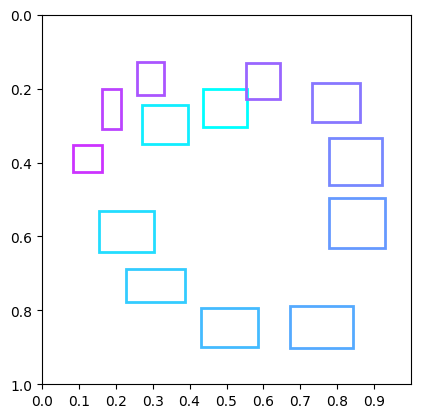

In [126]:
plot_raw_boxes_frames(bounding_boxes_spirel_gaps)

In [100]:
from iod2vot import ObjectTracker

In [131]:
tracker = ObjectTracker(max_distance=0.5, max_missing_frames=1)
tracker.analyse(bounding_boxes_spirel_gaps)

Running APSX object tracker on 16 frames
(0, array([0.20125, 0.436  , 0.305  , 0.556  ]))


<ipython-input-98-e2a1de10d47c>:98: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colour_map = plt.cm.get_cmap('cool', len(tracked_objects))


ploting object track  0


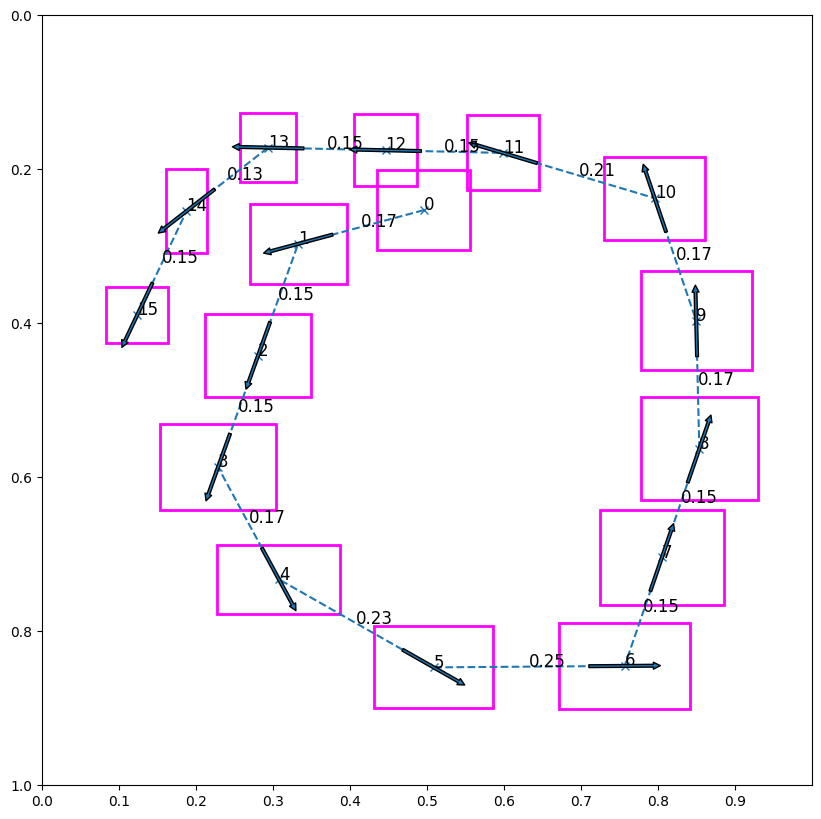

In [132]:
plot_object_tracker(tracker)

In [133]:
longest_track = tracker.get_longest_track()
longest_track.frames

[(0, array([0.20125, 0.436  , 0.305  , 0.556  ])),
 (1, array([0.245  , 0.27   , 0.34875, 0.396  ])),
 (2, array([0.388125, 0.212   , 0.495625, 0.35    ])),
 (3, array([0.53125, 0.154  , 0.6425 , 0.304  ])),
 (4, array([0.6875, 0.228 , 0.7775, 0.388 ])),
 (5, array([0.79375, 0.432  , 0.9    , 0.586  ])),
 (6, array([0.78875, 0.672  , 0.90125, 0.842  ])),
 (7, array([0.6425  , 0.725   , 0.765625, 0.886   ])),
 (8, array([0.49625, 0.778  , 0.63   , 0.93   ])),
 (9, array([0.3325 , 0.778  , 0.46125, 0.922  ])),
 (10, array([0.18375, 0.73   , 0.29125, 0.862  ])),
 (11, array([0.13  , 0.552 , 0.2275, 0.646 ])),
 (12, array([0.12875 , 0.405   , 0.221875, 0.488   ])),
 (13, array([0.1275 , 0.258  , 0.21625, 0.33   ])),
 (14, array([0.2    , 0.162  , 0.30875, 0.214  ])),
 (15, array([0.3525 , 0.084  , 0.42625, 0.164  ]))]

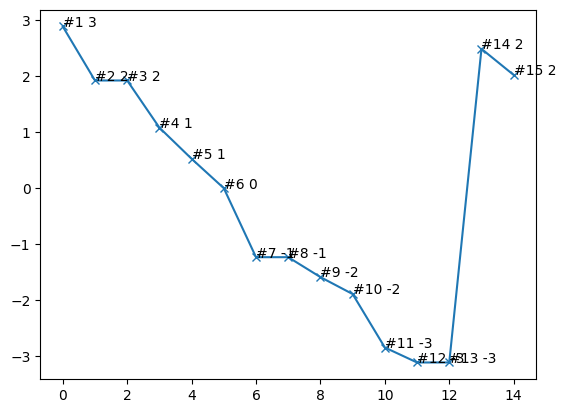

In [134]:
directions = longest_track.directions

plt.plot(directions, marker='x')
for i, d in enumerate(directions):
  plt.text(i, d, f'#{i+1} {round(d)}')

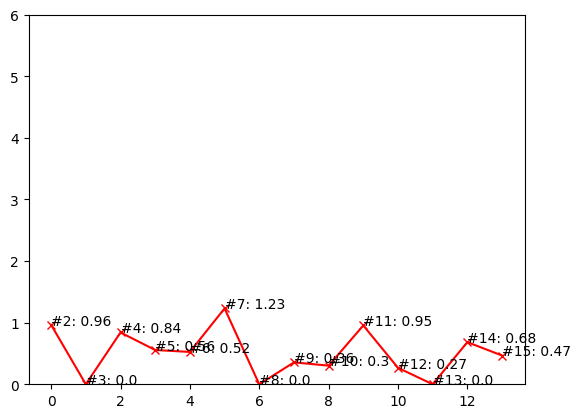

In [135]:
delta_directions = longest_track.delta_directions

plt.plot(delta_directions, marker='x',c='r')
plt.ylim(0,6)
for i, d in enumerate(delta_directions):
  plt.text(i, d, f'#{i+2}: {round(d,2)}')

plt.show()

<ipython-input-98-e2a1de10d47c>:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colour_map = plt.cm.get_cmap('cool', 5)


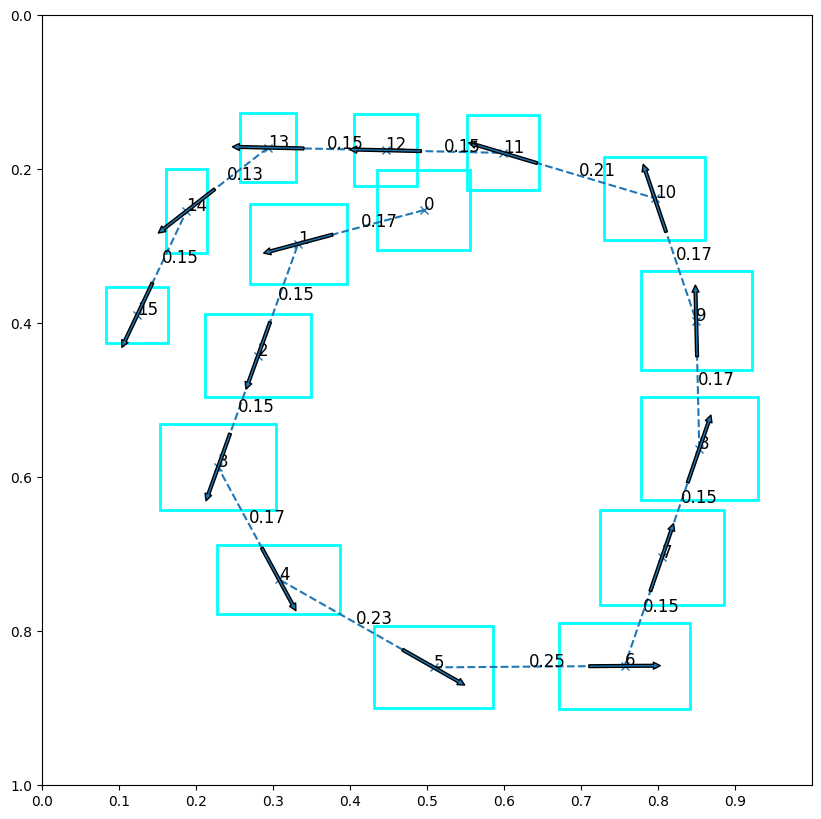

In [136]:
plot_single_tracked_object(longest_track)

<ipython-input-98-e2a1de10d47c>:131: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colour_map = plt.cm.get_cmap('cool', len(bboxes))


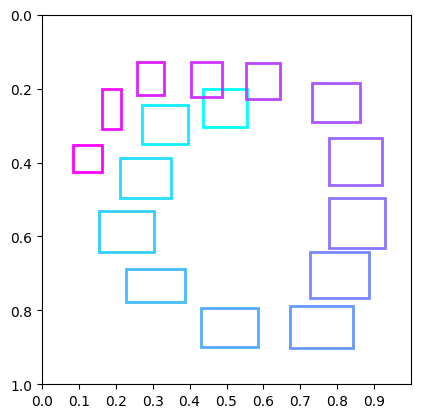

In [137]:
plot_raw_boxes(longest_track.bboxes)